In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np

from utils.Dataset import DatasetLoader
from models import network

In [2]:
model = network.build_model((448, 448, 3))
model.load_weights('./ckpt/yolo')
decoder = network.OutputDecoder(score_threshold=0.2)

In [3]:
inputs = model.input
out = decoder(model.output)
final_model = keras.models.Model(inputs, out)

In [4]:
train_ds, val_ds = DatasetLoader('./dataset/train_PASCAL2007.tfrecord', './dataset/val_PASCAL2007.tfrecord', 448, 7, 20).get_dataset(4)

In [32]:
for i in train_ds.take(7):
    sample = i
sample[0].shape, sample[1].shape

(TensorShape([4, 448, 448, 3]), TensorShape([4, 7, 7, 25]))

In [33]:
valid_num, nms_boxes, nms_scores, nmsed_classes = final_model.predict(sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 [161.55368 310.55875 403.5215  393.3082 ] 14.0
2 [145.76805 236.03514 413.41144 364.5105 ] 14.0
2 [162.28204 147.82672 408.19556 291.91534] 14.0
2 [115.08437 213.35211 340.23038 255.87201] 14.0
2 [187.29163   48.546844 386.30353  149.01593 ] 14.0
2 [180.4783  118.65216 387.8564  223.6615 ] 14.0
3 [148.98506 206.99622 309.85608 385.8755 ] 9.0


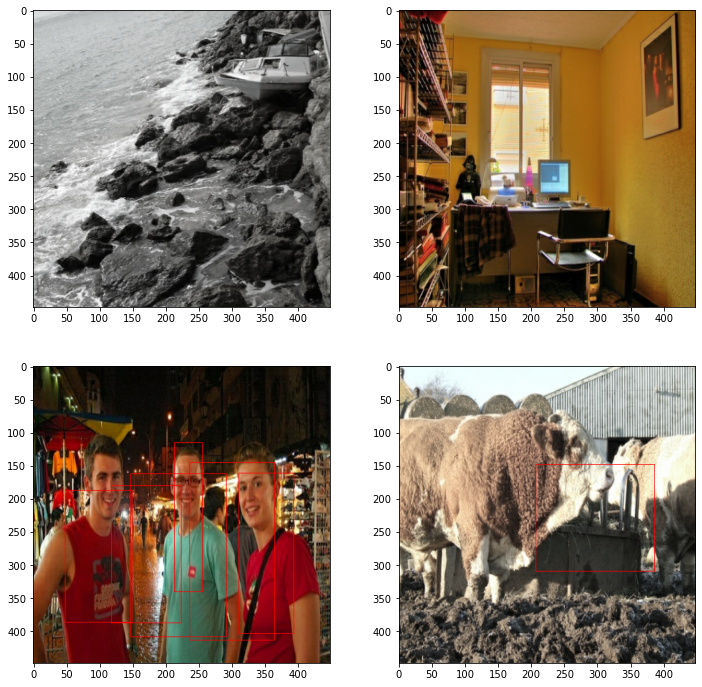

In [34]:
plt.figure(figsize=(12, 12))
for i in range(4):
    image = (sample[0][i].numpy())
    for box, name in zip(nms_boxes[i][:valid_num[i]], nmsed_classes[i][:valid_num[i]]):
        print(i, box, name)
        pt1 = (int(box[1]), int(box[0]))
        pt2 = (int(box[3]), int(box[2]))
        image = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 1)
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)

In [33]:
pred = model.predict(sample[0])

In [8]:
def get_confidence(conf, class_):
    confidence_score = class_ * conf
    return confidence_score

In [9]:
classes = tf.maximum(pred[..., 10:], 0.)

cond = tf.equal(classes, tf.reduce_max(classes, axis=[-1])[..., None])
classes = tf.where(cond, classes, tf.zeros_like(classes))

score1 = tf.maximum(pred[..., 4, None], 0.)
score1 = tf.reshape(get_confidence(score1, classes), (-1, 7 * 7, 20))
score2 = tf.maximum(pred[..., 4 + 5, None], 0.)
score2 = tf.reshape(get_confidence(score2, classes), (-1, 7 * 7, 20))
scores = tf.concat([score1, score2], axis=1)

In [10]:
tf.maximum(pred[..., 10:], 0.)[2, 2, 3]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.19062382, 0.01337794, 0.09648336, 0.        , 0.01354399,
       0.03430108, 0.12463775, 0.11597598, 0.09676876, 0.05471518,
       0.17533876, 0.00429745, 0.        , 0.03500545, 0.11741613,
       0.09628906, 0.03195423, 0.09642648, 0.        , 0.08319404],
      dtype=float32)>

In [11]:
cond[2, 2, 3]

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])>

In [12]:
np.where(pred[2][..., 4] == pred[2][..., 4].max())

(array([2], dtype=int64), array([4], dtype=int64))

In [13]:
pred[2, 2, 3, :5]

array([ 0.53402793,  1.3018337 ,  0.07816059,  0.14714296, -0.24813224],
      dtype=float32)

In [14]:
pred[2, 2, 3, 5:10]

array([ 2.3487354e-02,  1.9540193e+00, -1.2047431e+00,  8.9990206e-02,
       -1.7011287e-03], dtype=float32)